In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 7.5 MB/s eta 0:00:0000:0100:01m


In [1]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from mappings import *

In [2]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date

In [3]:
update_storage_access()

environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})



In [7]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True
)


In [4]:
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [97]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )
image.normalize()

In [6]:
from labeler import RILLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

labeler_RIL = RILLabeler(date, '973')

In [7]:
import rasterio

In [8]:
mask_RIL = labeler_RIL.create_segmentation_label(image)

In [9]:
from labeler import BDTOPOLabeler

labeler_BDTOPO = BDTOPOLabeler(date, '973')

In [10]:
mask_BDTOPO = labeler_BDTOPO.create_segmentation_label(image)

In [11]:
import geopandas as gpd
from shapely.geometry import Polygon
from rasterio.features import rasterize, shapes

In [44]:
image_height = image.array.shape[1]
image_width = image.array.shape[2]
polygon_list = []
for shape in list(shapes(mask_BDTOPO)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.85 * image_height * image_width:
        continue
    polygon_list.append(polygon)
    
# Créer un GeoSeries à partir de la liste de polygons
g_BDTOPO = gpd.GeoSeries(polygon_list)

In [46]:
polygon_list = []
for shape in list(shapes(mask_RIL)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.5 * image_height * image_width:
        continue
    polygon_list.append(polygon)
 
# Créer un GeoSeries à partir de la liste de polygons
g_RIL = gpd.GeoSeries(polygon_list)

In [125]:
result = gpd.sjoin(gdf_BDTOPO, gdf_RIL,how="inner",predicate = "intersects")

In [126]:
# Récupérer les géométries du résultat
geoms = result.values

In [127]:
polygon_result = []
for i in range(len(geoms)):
    polygon_result.append(geoms[i][0])
    

In [ ]:
gdf_result = gpd.GeoDataFrame(geometry = polygon_result, crs = labeler_BDTOPO.labeling_data.crs)

In [194]:
gdf_result = gdf_result.drop_duplicates()

In [196]:
g_result = gdf_result.geometry

<Axes: >

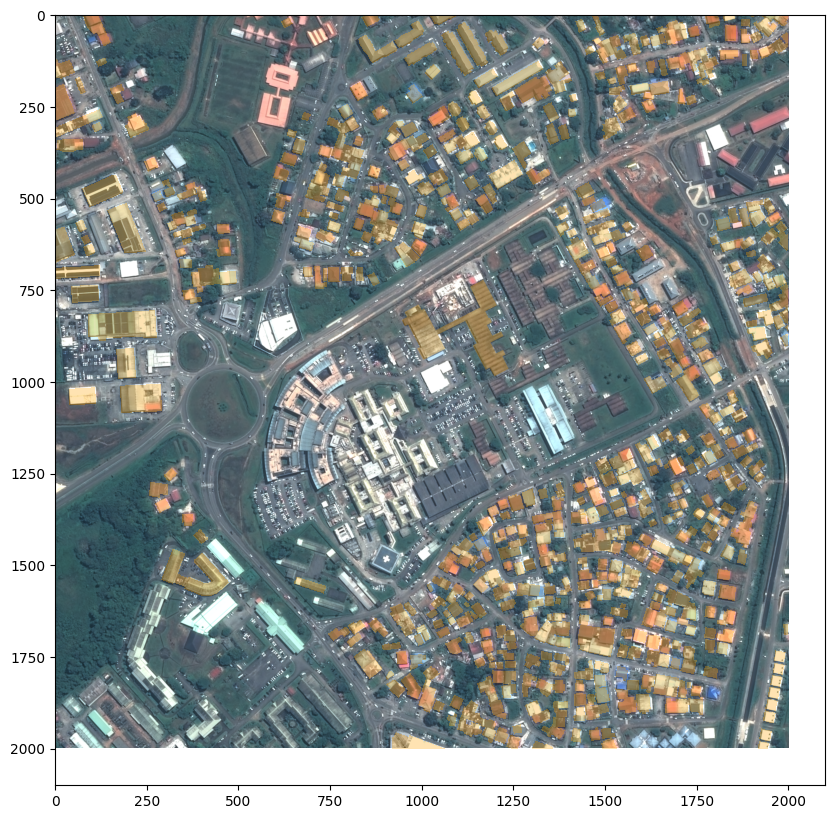

In [197]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g_result.plot(color = "orange", ax=ax, alpha=0.3)

In [245]:
xmin, ymin, xmax, ymax = image.bounds

In [243]:
patch = labeler_BDTOPO.labeling_data.cx[xmin:xmax, ymin:ymax].copy()    

In [161]:
patch.geometry

260      POLYGON Z ((353990.700 544971.400 10.000, 3539...
281      POLYGON Z ((353145.300 544230.200 14.600, 3531...
282      POLYGON Z ((353751.100 544688.900 10.300, 3537...
283      POLYGON Z ((353815.700 544563.800 9.800, 35382...
284      POLYGON Z ((353823.900 544585.900 10.200, 3538...
                               ...                        
67758    POLYGON Z ((353155.300 544364.300 8.300, 35314...
81577    POLYGON Z ((352954.700 544705.400 11.900, 3529...
81592    POLYGON Z ((353771.200 544143.200 11.000, 3537...
81610    POLYGON Z ((353034.900 544893.200 7.000, 35302...
81611    POLYGON Z ((353059.600 544556.500 8.200, 35305...
Name: geometry, Length: 660, dtype: geometry

In [216]:
gdf_result['geometry_withoutZ'] = gdf_result.geometry.copy()

enlevons le Z pour faire le merge

In [244]:
#fonction 1

# Définir une fonction pour enlever la coordonnée Z
def remove_z(coord):
    return (coord[0],coord[1])

# Appliquer la fonction à chaque polygone
patch['geometry_withoutZ'] = patch['geometry'].apply(lambda x: Polygon([remove_z(coord) for coord in x.exterior.coords]))


In [239]:
#fonction 2

from shapely.geometry import Polygon

# Fonction pour enlever la composante Z d'un polygon 3D
def remove_z(polygon):
    exterior_coords = [(x, y) for x, y, z in polygon.exterior.coords]
    interior_coords = []
    for interior in polygon.interiors:
        interior_coords.append([(x, y) for x, y, z in interior.coords])
    return Polygon(exterior_coords, interior_coords)

# Appliquer la fonction à la colonne de géométrie du GeoDataFrame
patch['geometry_withoutZ'] = patch['geometry'].apply(remove_z)

le merge ne marche avec aucune des fonctions... il ne manque plus que ca pour avoir le masque...

In [241]:
merged_gdf = patch.merge(gdf_result, on='geometry_withoutZ')

In [206]:
new_masque = rasterize(
                merged_gdf.geometry,
                out_shape=image.array.shape[1:],
                fill=0,
                out=None,
                transform=image.transform,
                all_touched=True,
                default_value=1,
                dtype=None,
                 )

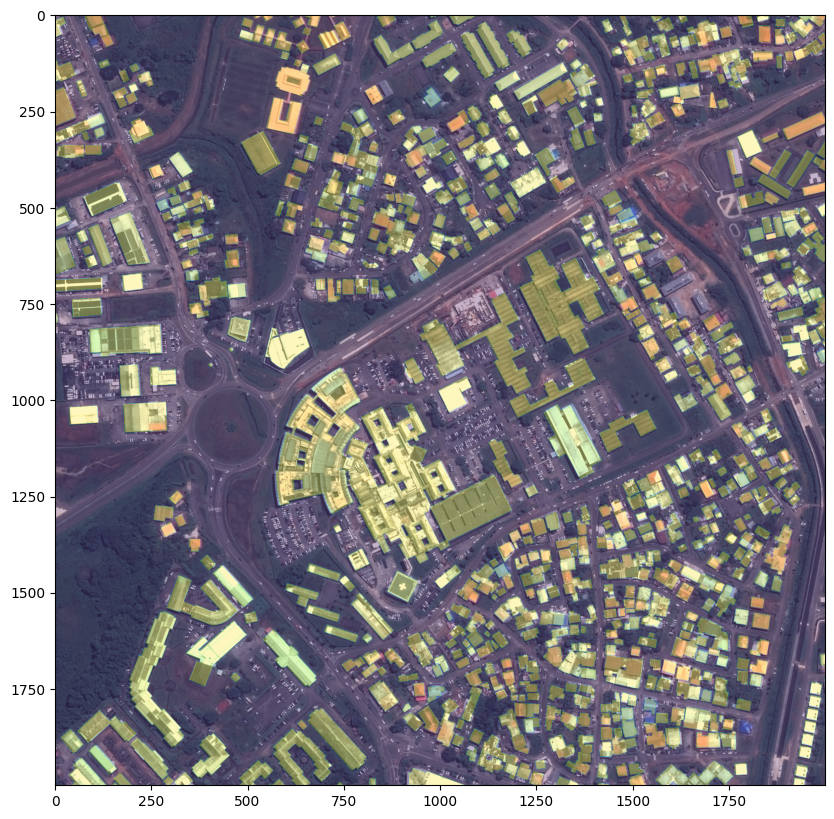

In [207]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(new_masque, alpha=0.3)